# MobileNet_V2



**June 2020**<br>
**Instructor:** Pavlos Protopapas<br>
**Lab Instructors:** Chris Gumb<br>
**Group members:** Hongshuo Wang, Simiao Zhao, Yijie Wang, Zixiang Jia<br> 

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from tensorflow.keras.layers import DepthwiseConv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Add, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
from PIL import Image, ImageOps
%matplotlib inline

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
n_GPUs = len(physical_devices)
print("Num GPUs Available: ", n_GPUs)
if n_GPUs > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


In [4]:
mobile_v2 = tf.keras.applications.MobileNetV2()

## Introduction




In order to obtain richer and more layered features, existing convolutional neural networks tend to make an issue of network width and depth.Although these methods improve the performance of the network, they also bring complex network structure and tedious parameter setting, which are greatly deficient in computing power, speed and storage space. These defects also hinder the implementation of some theoretically good network architecture projects in real applications. Therefore, MobileNets which  can construct an efficient network architecture comes out, and it introduces two hyperparameters to build a model with small volume and low latency.Today we will talk about mobilenets from seven parts .



## Architecture

 Depthwise Separable Convolution


The design of MobileNets is primarily based on deepwise separable convolution.The following figure shows a typical DeepWise separable convolution structure, which can be divided into two steps: Depthwise Conv and PointwiseConv.Compared with traditional convolution, the number of parameters is greatly reduced.

Depthwise Conv: Convolve according to the number of channels, allocate a convolution kernel for each channel, and the dimension of feature maps obtained is the number of input channels.

PointwiseConv: Concat the feature mapsobtained in the first step and carry out 1x1 convolution.The output of the final depth separable convolution is obtained.


In general, Deepwise separable convolution can be seen as a form of decomposition convolution, which decomposes the standard convolution into deep convolution and point convolution (1x1 convolution).In MobileNets, in the depthwise conv stage, a convolution kernel is applied for each channel of the input featuremap, and then in the pointwiseconv stage, the featuremap obtained in the first step is combined with the convolution of 1x1 to obtain the final output.A standard convolution filters and combines inputs into a new set of outputs in one step, while in a deeply separable convolution, the process is split in two, filtered first, and then merged.The effect of this convolution decomposition is to greatly reduce the computation and model size.Specifically, it can be expressed as:
standard:
![jupyter](./untitled1.png)
(Where, N is the number of convolution kernels, and Dk is the size of the convolution kernel.)

The following figure shows the convolution kernel in standard convolution. There are N convolution kernels, and the channel number of each convolution kernel is equal to the channel number of the input feature
![jupyter](./untitled2.png)
Then the output of standard convolution can be expressed as:
![jupyter](./untitled3.png)
cost:
![jupyter](./untitled4.png)

Deepwise separable convolution:
![jupyter](./untitled5.png)

Deepwise separable convolution consists of deepwise convolution and pointwise convolution. One convolution kernel is applied to each input channel using deepwise convolution. And then do a simple 1 * 1 convolution,
![jupyter](./untitled6.png)
output of Deepwise separable convolution 
![jupyter](./untitled7.png)
costs:
deepwise Conv cost：
![jupyter](./untitled8.png)
pointwise Conv cost：
![jupyter](./untitled9.png)
total：
![jupyter](./untitled10.png)
compare parameter ratio of standard and deepwise separable 
![jupyter](./untitled11.png)
The larger the number of convolution kernels, the larger the size, and the more significant the parameter reduction. we will demonstrate with an example.

Let’s say we have a 3x3 convolutional layer on 16 input channels and 32 output channels. What happens in detail is that every of the 16 channels is traversed by 32 3x3 kernels resulting in 512 (16x32) feature maps. Next, we merge 1 feature map out of every input channel by adding them up. Since we can do that 32 times, we get the 32 output channels we wanted.

For a depthwise separable convolution on the same example, we traverse the 16 channels with 1 3x3 kernel each, giving us 16 feature maps. Now, before merging anything, we traverse these 16 feature maps with 32 1x1 convolutions each and only then start to them add together. This results in 656 (16x3x3 + 16x32x1x1) parameters opposed to the 4608 (16x32x3x3) parameters from above.
The example is a specific implementation of a depthwise separable convolution where the so called depth multiplier is 1. This is by far the most common setup for such layers.

We do this because of the hypothesis that spatial and depthwise information can be decoupled. Looking at the performance of the Xception model this theory seems to work. Depthwise separable convolutions are also used for mobile devices because of their efficient use of parameters.




Model: "Standard Convolution"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12, 12, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         19456     
Total params: 19,456
Trainable params: 19,456
Non-trainable params: 0
_________________________________________________________________
Model: "Depth-Wise Separable Convolution"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 12, 12, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 3)           228       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         1024      


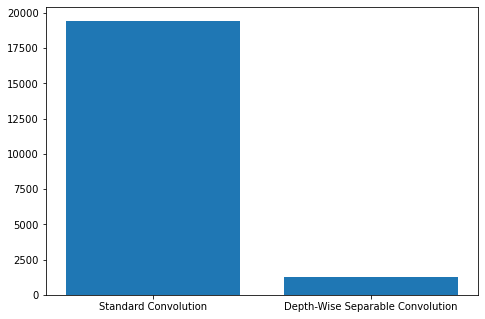

Number of paremeters 
Standard Convolution: 19456
Depth-Wise Separable Convolution: 1252


In [5]:
def standard_conv(x):
    input_x =  tf.keras.Input(shape=x)
    output = Conv2D(256, (5,5), activation='relu')(input_x) 
    model = tf.keras.Model(input_x, output, name='Standard Convolution')
    return model

def depth_wise_separable_conv(x):
    input_x =  tf.keras.Input(shape=x)
    m = Conv2D(3, (5,5), activation='relu')(input_x)
    output = Conv2D(256, (1,1), activation='relu')(m)
    model = tf.keras.Model(input_x, output, name='Depth-Wise Separable Convolution')
    return model


x = (12, 12, 3)
standard_conv = standard_conv(x)
depthwise_conv = depth_wise_separable_conv(x)

assert standard_conv.count_params() > depthwise_conv.count_params(), "residual block has less parameters"
standard_conv.summary()
depthwise_conv.summary()

print('\n\n\n')


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Standard Convolution', 'Depth-Wise Separable Convolution']
y = [standard_conv.count_params(), depthwise_conv.count_params()]
ax.bar(x,y)
plt.show()



print(f'Number of paremeters \nStandard Convolution: {standard_conv.count_params()}')
print(f'Depth-Wise Separable Convolution: {depthwise_conv.count_params()}')



Now, we can take a look at the entire architecture.
The following figure shows the structure of a block in MobileNets. It can be seen that MobileNets adds BN layer and ReLu layer after depthwise Conv and Pointwise Conv compared with traditional convolution.
![jupyter](./untitled12.png)
With the basic structure in place, we can look at the structure of the MobileNet body
![jupyter](./untitled13.png)

In MobileNets V2, the basic structural component is a deeply separable convolution with residuals.
remind in MobileNets ， it based on deepwise sparable convolution，firstly deepthwiseconv，then pointwise conv, then get final features. 
![jupyter](./untitled19.png)
but in MobileNets v2，Linearbottlenecks and Inverted Residuals is induced，on the basic structure of v1，before depthwiseconv，proceed a 1x1 convolution，for rising dimension. Also after dimension reduction，we dont use non-linear activition function such as ReLU. Shortcut connections are made if and only if the input-output dimensions are identical.So here are two structures
![jupyter](./untitled20.png)

In [6]:
mobile_v2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [7]:
tf.keras.utils.plot_model(
    mobile_v2,
    #to_file='model.png', # if you want to save the image
    show_shapes=True, # True for more details than you need
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# ReLU6




The snippet above shows the structure of a convolutional block that incorporates inverted residuals and linear bottlenecks. 
As u notice,In order to make the RuLU function have a good numerical resolution even in the case of low precision of mobile devices, the activation range of ReLU function is limited. Experiments show that the output limit of ReLU is 6, which is the best effect. In this way, the restricted function is renamed as ReLU6. we use ReLU6 instead of ReLU, which limits the value of activations to a maximum of 6. The activation is linear as long as it’s between 0 and 6.

In [8]:
mobile_v2.get_layer(name='block_15_expand_relu')


In [9]:
def relu(z: np.array) -> np.array:
    h = np.maximum(0,z)
    return h


def relu6(z: np.array) -> np.array:
    h = np.minimum(np.maximum(0,z), 6)
    return h

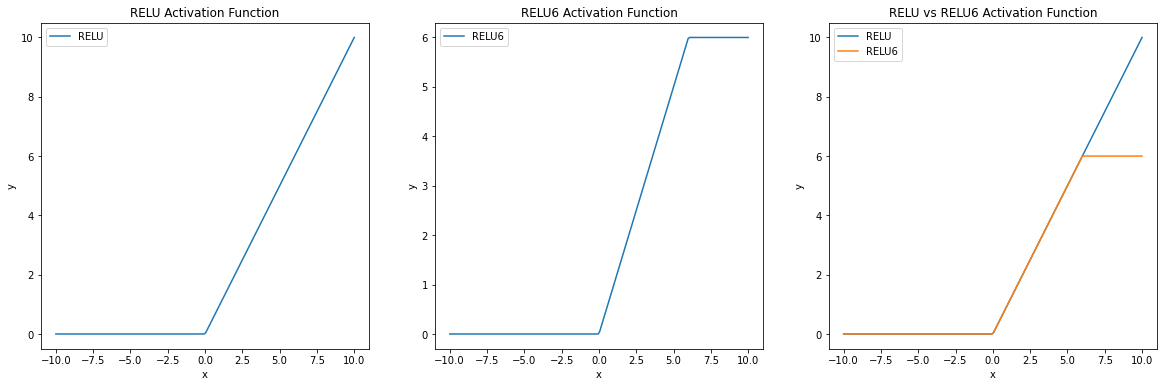

In [10]:
def plot_activation_func(f1,f2):
    fig, ax = plt.subplots(1,3, figsize=(20,6))
    lin_x = np.linspace(-10,10,200)
    h_1 = f1(lin_x)
    h_2 = f2(lin_x)
    for i in range(3):
        ax[i].set_xlabel('x')
        ax[i].set_ylabel('y')
        
   

    ax[0].set_title('RELU Activation Function')
    ax[1].set_title('RELU6 Activation Function')
    ax[2].set_title('RELU vs RELU6 Activation Function')
    
    ax[0].plot(lin_x, h_1)
    ax[1].plot(lin_x, h_2)
    ax[2].plot(lin_x, h_1)
    ax[2].plot(lin_x, h_2)
    
    
    
    ax[0].legend(['RELU'], loc='best')
    ax[1].legend(['RELU6'], loc='best')
    ax[2].legend(['RELU', 'RELU6'], loc='best')
    
    
plot_activation_func(relu, relu6)

This is helpful when you’re dealing with fixed point inference. It limits the information left of the decimal point to 3 bits, meaning we have a guaranteed precision right of the decimal point. This was also used in the orignal MobileNet paper. The final building block looks like this:

## Inverted Residuals

Before we move to the inverted residuals, let's first have a glance of original ResNet. Inside residual blocks the skip connection connects the begining and the end of the blocks. By doing so, skip connection pass information that may be lost due to depth of layers. This approach overcomes the issue of vanishing gradients and hence help in building network of great depth.

The origin residual block follows a wide->narrow->wide structure concerning the number of channels. To make the 3x3 convolution faster and easier to train, the input is firstly conpressed by a 1x1 convolution. After 3x3 convolution, the number of channels is expansed by another 1x1 convolution in order to keep input and output share the same dimension. 
![jupyter](./untitled17.png)

MobilenetV2 has combined the skip connection and depthwise convolutions together. Comparing to the original residual block, the most significant change is that MobileNetV2 follows a narrow->wide->narrow approach. That's why it is called inverted residuals. The depthwise convolution already greatly reduces the number of parameters, as a result it is no longer necessary to reduce the number of channels in the first step. On the contrary, the network is firstly widened using a 1x1 convolution. After a depthwise convolution another 1x1 convolution squeezes the network in order to match the initial number of channels.By doing so, we can filter higher dimensional data and extract more useful information. In this figure you can see that skip connections exist between narrow parts of the network which is opposite of how an original residual connection works.In the next part we will talk about the advantage behind this approach.
![jupyter](./untitled20.png)
![jupyter](./untitled18.png)


### Comparsion between Residual Block and Inverted Residual Block

Model: "Residual_block"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 14, 14, 384) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   24640       input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 384)  24960       conv2d_4[0][0]                   
_____________________________________________________________________________________

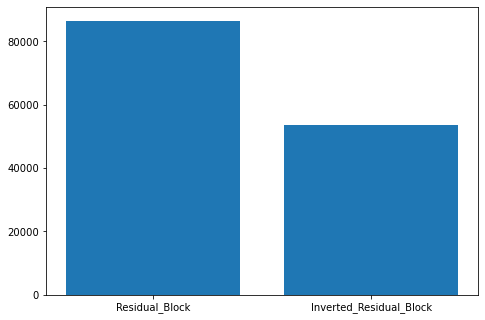

Number of paremeters 
Residual_block: 86528
Inverted_residual_block: 53440


In [11]:

def relu6(z):
    return tf.nn.relu6(z)


def residual_block(x):
    input_x =  tf.keras.Input(shape=x)
    m = Conv2D(x[2]/6, (1,1), activation='relu')(input_x)
    m = Conv2D(x[2]/6, (3,3), activation='relu',  padding='same')(m)
    m = Conv2D(x[2], (1,1), activation='relu')(m)
    output = Add()([m, input_x])
    model = tf.keras.Model(input_x, output, name='Residual_block')
    return model


def inverted_residual_block(x):
    input_x =  tf.keras.Input(shape=x)
    m = Conv2D(x[2]*6, (1,1), activation=relu6)(input_x)
    m = DepthwiseConv2D((3,3), activation=relu6, padding='same')(m)
    m = Conv2D(x[2], (1,1), activation=relu6)(m)
    output = Add()([m, input_x])
    model = tf.keras.Model(input_x, output, name='Inverted_residual_block')
    return model



x = (14, 14, 64)
x_residual = (14, 14, 64*6)
residual_block= residual_block(x_residual)

inverted_residual_block = inverted_residual_block(x)

assert residual_block.count_params() > inverted_residual_block.count_params(), "residual block has less parameters"
residual_block.summary()
inverted_residual_block.summary()

print('\n\n\n')


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Residual_Block', 'Inverted_Residual_Block']
y = [residual_block.count_params(),inverted_residual_block.count_params()]
ax.bar(x,y)
plt.show()



print(f'Number of paremeters \nResidual_block: {residual_block.count_params()}')
print(f'Inverted_residual_block: {inverted_residual_block.count_params()}')


The inverted residual block have fewer parameters camparing to the original residual block.

## Linear Bottlenecks


In the first lecture, we have learnt that activation is an essetial part of neural networks by introducing non-linearity into the network. At the same time the activation function ReLU discards values that are smaller than 0. ReLU can bring information loss, and there is no way to recover this loss. The information loss of ReLU is more significant when the number of channels is very small. From Figure, we can see that when original input dimension is relatively small(2~3), the information loss of ReLU is very serious, but when the dimension increased to 15 or 30, the input manifold can be restored very well.
![jupyter](./untitled16.png)

In inverted residual blocks we expand the number of channels in the first layer, which means it is still reasonable to use RELU6. However, in the third layer the network is squeezed to lower dimension, where RELU6 can cause information loss. The authors introduced the idea of a linear bottleneck where the last convolution of a residual block has a linear output. Putting this into code is super simple as we simply discard the last activation function of the convolutional block:
![jupyter](./untitled24.png)

In [12]:
def inverted_linear_residual_block(x):
    input_x =  tf.keras.Input(shape=x)
    m = Conv2D(x[2]*6, (1,1), activation=relu6)(input_x)
    m = DepthwiseConv2D((3,3), activation=relu6, padding='same')(m)
    m = Conv2D(x[2], (1,1), activation='linear')(m)
    output = Add()([m, input_x])
    model = tf.keras.Model(input_x, output, name='Inverted_linear_residual_block')
    return model


x = (14, 14, 64)
inverted_linear_residual_block = inverted_linear_residual_block(x)
inverted_linear_residual_block.summary()

Model: "Inverted_linear_residual_block"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 14, 14, 64)] 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 384)  24960       input_6[0][0]                    
__________________________________________________________________________________________________
depthwise_conv2d_1 (DepthwiseCo (None, 14, 14, 384)  3840        conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 64)   24640       depthwise_conv2d_1[0][0]         
_____________________________________________________________________

### Final_bottleneck block

In [13]:
def bottleneck_block(x):
    input_x =  tf.keras.Input(shape=x)
    m = Conv2D(x[2]*6, (1,1))(input_x)
    m = BatchNormalization()(m)
    m = Activation(activation =relu6)(m)
    m = DepthwiseConv2D((3,3), padding='same')(m)
    m = BatchNormalization()(m)
    m = Activation(activation =relu6)(m)
    m = Conv2D(x[2], (1,1))(m)
    m = BatchNormalization()(m)
    m = Activation('linear')(m)
    output = Add()([m, input_x])
    model = tf.keras.Model(input_x, output, name='bottleneck_block')
    return model

x = (14, 14, 64)
bottleneck_block = bottleneck_block(x)
bottleneck_block.summary()

Model: "bottleneck_block"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 14, 14, 64)] 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 384)  24960       input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 384)  1536        conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 14, 14, 384)  0           batch_normalization[0][0]        
___________________________________________________________________________________

## Comparsion

Accuracy is improved by removing non-linear activation at the output of last layer in the inverted residual block.
![jupyter](./untitled25.png)

accuracy is improved by applying inverted residuals comparing to resnet and no residual.
![jupyter](./untitled26.png)

## Transfer Learning on Sign Language Datasets

<div class='gc'><b>Image Preparation</b></div>
<br>
This is a dataset of the sign language gestures for the digits 0-9. It is available on GitHub in color (Kaggle only has the B&W version).<br>
Dataset:<br>

https://github.com/ardamavi/Sign-Language-Digits-Dataset<br>

After introducing the architecture of Mobilenetv2, we implement a demo to demonstrate our model by using transfer learning on sign language digits datasets. Besides modifying the output layers from 1000 classes to 10 classes, we also freeze the first half of model, and only train 10th -16th bottle blocks since the pretrained model has already learnt lots of edges and corners details in the first half of weights. All we need to do is training the last half of model to classify images. It took 20 minus to train on GPU in order to get our desired results. You can see further details in our notebook.

In [14]:
os.chdir('data/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [15]:
for i in range(0, 10):
    assert len(os.listdir(f'data/Sign-Language-Digits-Dataset/valid/{i}')) == 30
    assert len(os.listdir(f'data/Sign-Language-Digits-Dataset/test/{i}')) == 5

In [16]:
train_path = 'data/Sign-Language-Digits-Dataset/train'
valid_path = 'data/Sign-Language-Digits-Dataset/valid'
test_path = 'data/Sign-Language-Digits-Dataset/test'

In [17]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(100,100), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(100,100), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(100,100), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [18]:
assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

<div class='gc'><b>Load New MobileNet</b></div>
<br>
Using pretrained weight as the basic


In [19]:
mobile = tf.keras.applications.MobileNetV2()

In [20]:
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

Change the output classified classes from 1000 classes (default) to 10 (0-9 digits) classes

In [21]:
x = mobile.layers[-2].output
output = Dense(units=10, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)

In [22]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

We also freeze the first half of model, and only train 10th -16th bottle blocks since the pretrained model has already learnt lots of edges and corners details in the first half of weights. All we need to do is training the last half of model to classify images.



In [23]:
# your code here
for layer in model.layers[:-66]:
    layer.trainable = False

### Train the model and display the result

In [24]:
model.compile(optimizer=Adam(lr=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Run for more epochs (~30) to see better results
history = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=30,
          verbose=2
)

Epoch 1/30
172/172 - 35s - loss: 0.9821 - accuracy: 0.6624 - val_loss: 2.7600 - val_accuracy: 0.4500
Epoch 2/30
172/172 - 34s - loss: 0.3239 - accuracy: 0.8919 - val_loss: 2.6251 - val_accuracy: 0.5400
Epoch 3/30
172/172 - 34s - loss: 0.2069 - accuracy: 0.9334 - val_loss: 1.1370 - val_accuracy: 0.7700
Epoch 4/30
172/172 - 34s - loss: 0.1364 - accuracy: 0.9556 - val_loss: 0.4381 - val_accuracy: 0.8700
Epoch 5/30
172/172 - 34s - loss: 0.1545 - accuracy: 0.9550 - val_loss: 0.3295 - val_accuracy: 0.9233
Epoch 6/30
172/172 - 34s - loss: 0.1072 - accuracy: 0.9696 - val_loss: 0.2827 - val_accuracy: 0.9267
Epoch 7/30
172/172 - 34s - loss: 0.0810 - accuracy: 0.9755 - val_loss: 0.4215 - val_accuracy: 0.9033
Epoch 8/30
172/172 - 36s - loss: 0.1148 - accuracy: 0.9597 - val_loss: 0.3244 - val_accuracy: 0.9233
Epoch 9/30
172/172 - 35s - loss: 0.0638 - accuracy: 0.9819 - val_loss: 0.3870 - val_accuracy: 0.9367
Epoch 10/30
172/172 - 34s - loss: 0.0602 - accuracy: 0.9790 - val_loss: 0.3909 - val_accura

In [26]:
test_labels = test_batches.classes

In [27]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [28]:
model.evaluate(test_batches, steps=len(test_batches))

5/5 [==============================] - 0s 68ms/step - loss: 4.3873e-04 - accuracy: 1.0000


[0.00043872714741155505, 1.0]

In [29]:
model.save_weights('mobilev2_model')
model.load_weights('mobilev2_model')

## Visualizing the Model

Model visualization can increase the readability of the model, and output in a visual form described to the non-technical persons. At the same time, it also gives us insights into its internal workings and offers directions for removing bias and improving its performance. In fact, since the accuracy based on numbers is sometimes unreliable, a more intuitive performance of the classifier is necessary.

In the next part, we will visualize the training process and testing process of the model to check whether MobileNets v2 can work well on the dataset of the sign language gestures.

# presentation

First, we look at the gestures in 0-9 files that have been spilted by ImageDataGenerator, and select the required test image

In [30]:
def prepare_image(file):
    img = load_img(file, target_size=(243, 243))
    # convert the image pixels to a numpy array
    img_array = img_to_array(img)
    # reshape data for the model
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    # preprocess the image for the MobileNet model
    img_preprocessed = preprocess_input(img_array_expanded_dims)
    return img_preprocessed

In [31]:
sign0 = prepare_image('data/Sign-Language-Digits-Dataset/test/0/IMG_5007.JPG')
sign1 = prepare_image('data/Sign-Language-Digits-Dataset/test/1/IMG_1119.JPG')
sign2 = prepare_image('data/Sign-Language-Digits-Dataset/test/2/IMG_4042.JPG')
sign3 = prepare_image('data/Sign-Language-Digits-Dataset/test/3/IMG_4196.JPG')
sign4 = prepare_image('data/Sign-Language-Digits-Dataset/test/4/IMG_1122.JPG')
sign5 = prepare_image('data/Sign-Language-Digits-Dataset/test/5/IMG_4271.JPG')
sign6 = prepare_image('data/Sign-Language-Digits-Dataset/test/6/IMG_4282.JPG')
sign7 = prepare_image('data/Sign-Language-Digits-Dataset/test/7/IMG_4230.JPG')
sign8 = prepare_image('data/Sign-Language-Digits-Dataset/test/8/IMG_1187.JPG')
sign9 = prepare_image('data/Sign-Language-Digits-Dataset/test/9/IMG_4390.JPG')
image_list = [sign0, sign1, sign2, sign3, sign4, sign5, sign6, sign7, sign8, sign9]

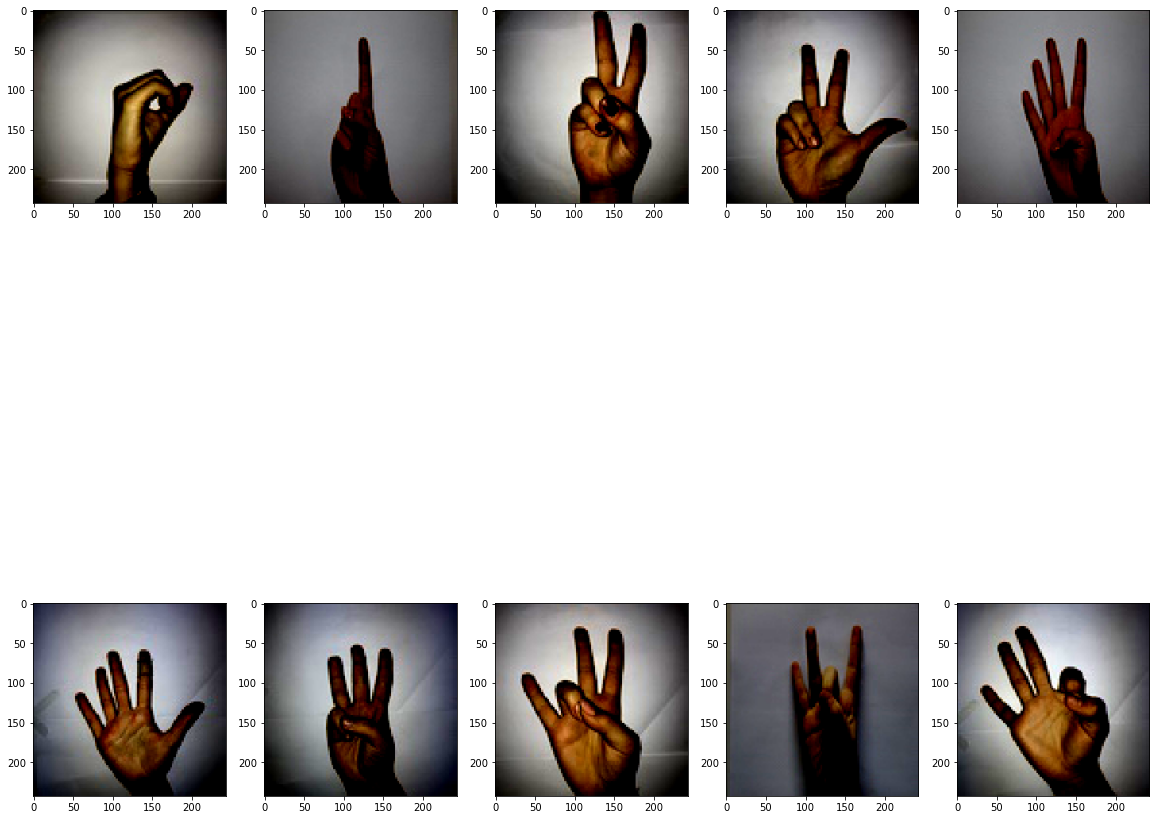

In [32]:
fig,ax = plt.subplots(2,5,figsize=(20,20))
ax[0][0].imshow(np.clip(sign0[0],0,1))
ax[0][1].imshow(np.clip(sign1[0],0,1))
ax[0][2].imshow(np.clip(sign2[0],0,1))
ax[0][3].imshow(np.clip(sign3[0],0,1))
ax[0][4].imshow(np.clip(sign4[0],0,1))
ax[1][0].imshow(np.clip(sign5[0],0,1))
ax[1][1].imshow(np.clip(sign6[0],0,1))
ax[1][2].imshow(np.clip(sign7[0],0,1))
ax[1][3].imshow(np.clip(sign8[0],0,1))
ax[1][4].imshow(np.clip(sign9[0],0,1))

In [33]:
pred_list = []
for i in image_list:
    pred_list.append(np.argmax(model.predict(i)))
pred_list

[0, 1, 0, 1, 7, 1, 6, 0, 7, 1]

<div class='exercise'><b>Visualizing Training Process</b></div>

In the first step, we visualize the training process.

We already know that in the structure of MobileNet V2, a block based on the inversion residual and linear bottleneck has 9 layers, and the blocks are connected end to end through the inversion residual. 

In order to match the training set, when transfer Learning on Sign Language Datasets, based on MobileNet V2 provided by keras, we added softmax as the activation function of the output layer. Meanwhile, we made the layers after the sixth block untrainable. 

Therefore, the model we used for training (including the untrainable state) has a total of:

10(input+first block) + 16(repeated block)*9 + 5(output) = 157 $ layers.

In [34]:
def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output]) 
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

When visualizing the training process, we choose to visualize the input layer, middle layer, and output layer of the first block. This process will visually show the effect of adding Depthwise when import inversion residual and also the influence of deleting the relu of the output layer when import linear bottleneck. 

We first check that all the visualizing layers are correct, and then call `get_feature_maps` from lab7 to show the 9 feature maps of the above three stages.

In [35]:
print(f'{model.layers[10].output}\n{model.layers[12].output}\n{model.layers[14].output}\n{model.layers[17].output}')

Tensor("block_1_expand/Conv2D_1:0", shape=(None, 112, 112, 96), dtype=float32)
Tensor("block_1_expand_relu/Relu6_1:0", shape=(None, 112, 112, 96), dtype=float32)
Tensor("block_1_depthwise/depthwise_1:0", shape=(None, 56, 56, 96), dtype=float32)
Tensor("block_1_project/Conv2D_1:0", shape=(None, 56, 56, 24), dtype=float32)


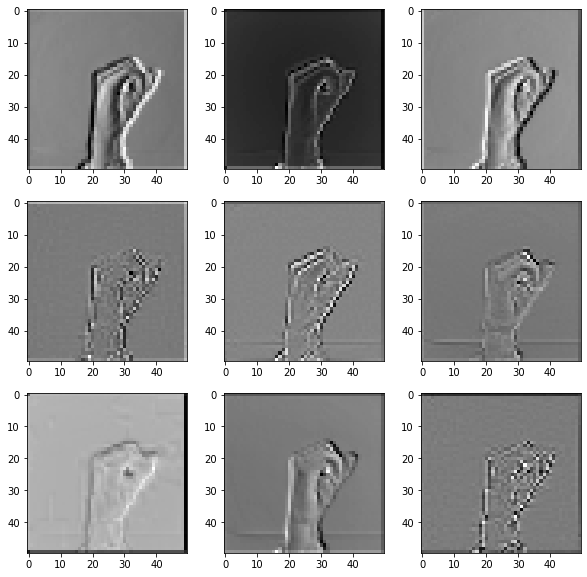

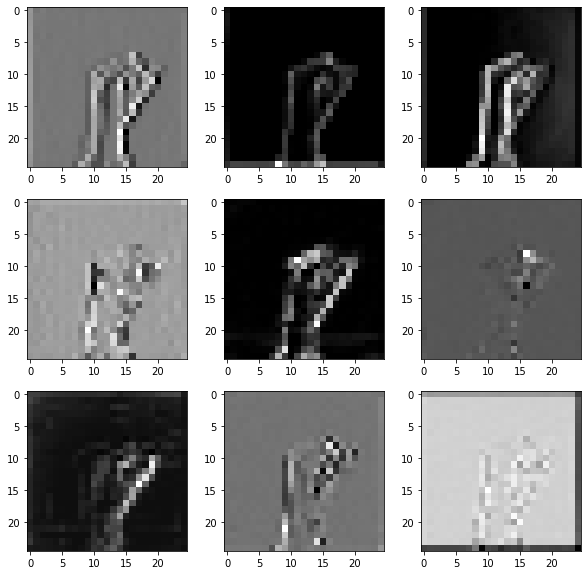

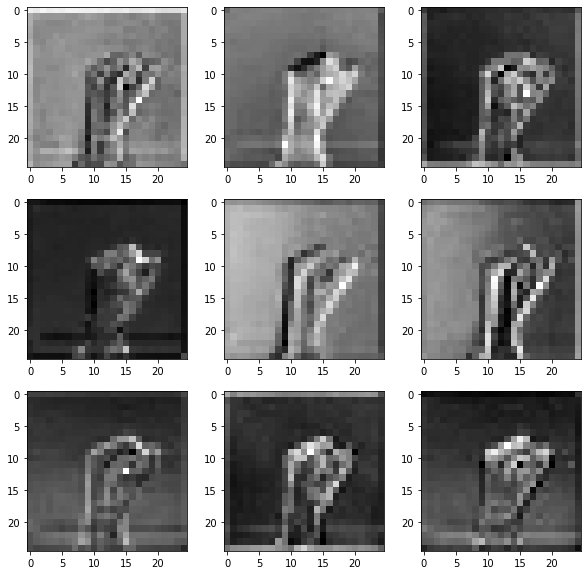

In [36]:
input_layer = get_feature_maps(model, 10,  test_batches[0][0][0])[0:9]
fig, ax = plt.subplots(3,3, figsize = (10,10))
for i, feature in enumerate(input_layer):
    ax.ravel()[i].imshow(feature, cmap = "gray")
    
middle_layer = get_feature_maps(model, 14,  test_batches[0][0][0])[0:9]
fig, ax = plt.subplots(3,3, figsize = (10,10))
for i, feature in enumerate(middle_layer):
    ax.ravel()[i].imshow(feature, cmap = "gray")
    
output_layer = get_feature_maps(model, 17,  test_batches[0][0][0])[0:9]
fig, ax = plt.subplots(3,3, figsize = (10,10))
for i, feature in enumerate(output_layer):
    ax.ravel()[i].imshow(feature, cmap = "gray")

Then we select the 5th, 10th, 15th block and the final output layer for visualization. 

It can be seen that the appearance after the 10th block has been overly blurred, which proves that it is necessary to freeze the weights of the first half of blocks in order to ensure that the transfer learning process successfully learns things outside the original domain.

In [37]:
print(f'{model.layers[10].output}\n{model.layers[19].output}\n{model.layers[28].output}\n'
      f'{model.layers[37].output}\n{model.layers[46].output}\n{model.layers[55].output}\n'
      f'{model.layers[64].output}\n{model.layers[73].output}\n{model.layers[82].output}\n'
      f'{model.layers[91].output}\n{model.layers[99].output}\n{model.layers[108].output}\n'
      f'{model.layers[117].output}\n{model.layers[126].output}\n{model.layers[135].output}\n'
      f'{model.layers[144].output}\n{model.layers[152].output}\n{model.layers[156].output}')

Tensor("block_1_expand/Conv2D_1:0", shape=(None, 112, 112, 96), dtype=float32)
Tensor("block_2_expand/Conv2D_1:0", shape=(None, 56, 56, 144), dtype=float32)
Tensor("block_3_expand/Conv2D_1:0", shape=(None, 56, 56, 144), dtype=float32)
Tensor("block_4_expand/Conv2D_1:0", shape=(None, 28, 28, 192), dtype=float32)
Tensor("block_5_expand/Conv2D_1:0", shape=(None, 28, 28, 192), dtype=float32)
Tensor("block_6_expand/Conv2D_1:0", shape=(None, 28, 28, 192), dtype=float32)
Tensor("block_7_expand/Conv2D_1:0", shape=(None, 14, 14, 384), dtype=float32)
Tensor("block_8_expand/Conv2D_1:0", shape=(None, 14, 14, 384), dtype=float32)
Tensor("block_9_expand/Conv2D_1:0", shape=(None, 14, 14, 384), dtype=float32)
Tensor("block_10_expand/Conv2D_1:0", shape=(None, 14, 14, 384), dtype=float32)
Tensor("block_11_expand/Conv2D_1:0", shape=(None, 14, 14, 576), dtype=float32)
Tensor("block_12_expand/Conv2D_1:0", shape=(None, 14, 14, 576), dtype=float32)
Tensor("block_13_expand/Conv2D_1:0", shape=(None, 14, 14, 57

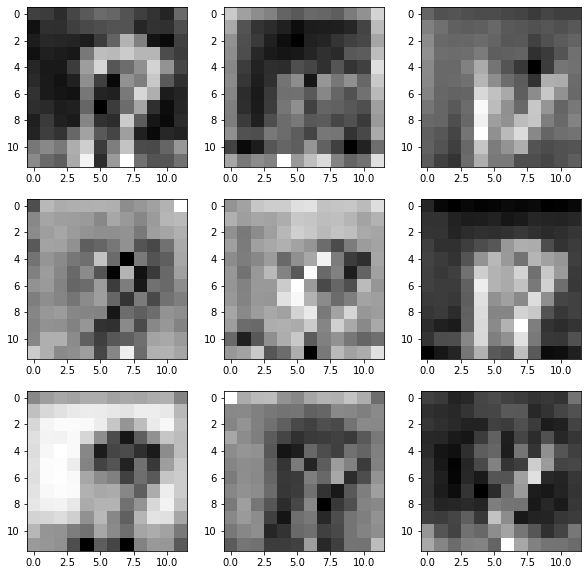

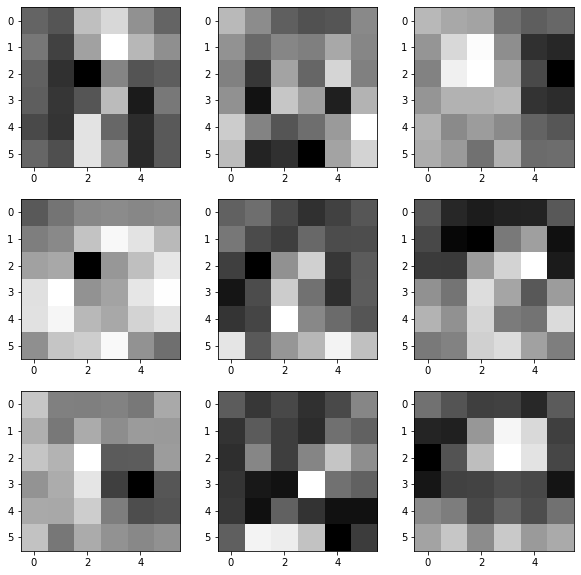

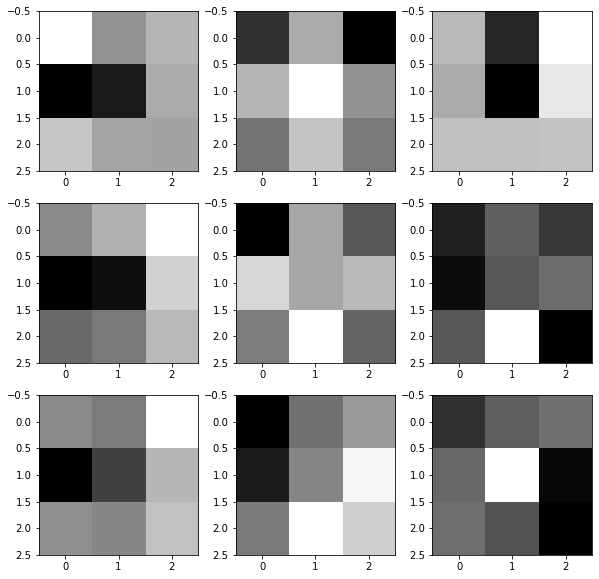

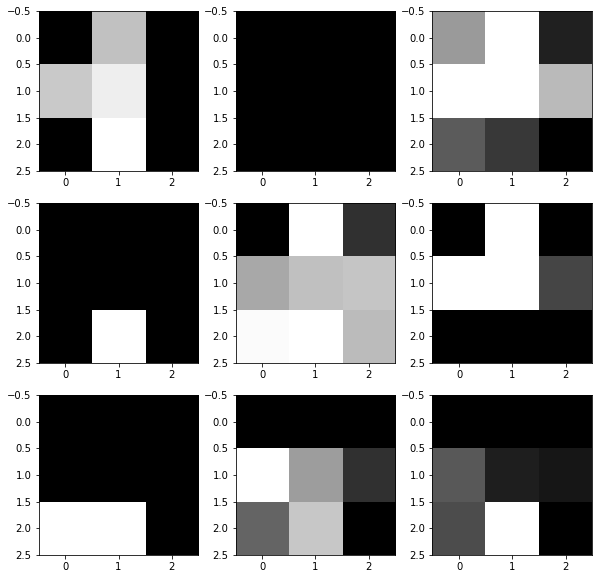

In [38]:
block5 = get_feature_maps(model, 46,  test_batches[0][0][0])[0:9]
fig, ax = plt.subplots(3,3, figsize = (10,10))
for i, feature in enumerate(block5):
    ax.ravel()[i].imshow(feature, cmap = "gray")

block10 = get_feature_maps(model, 91,  test_batches[0][0][0])[0:9]
fig, ax = plt.subplots(3,3, figsize = (10,10))
for i, feature in enumerate(block10):
    ax.ravel()[i].imshow(feature, cmap = "gray")
    
block15 = get_feature_maps(model, 135,  test_batches[0][0][0])[0:9]
fig, ax = plt.subplots(3,3, figsize = (10,10))
for i, feature in enumerate(block15):
    ax.ravel()[i].imshow(feature, cmap = "gray")
    
final_output = get_feature_maps(model, 154,  test_batches[0][0][0])[0:9]
fig, ax = plt.subplots(3,3, figsize = (10,10))
for i, feature in enumerate(final_output):
    ax.ravel()[i].imshow(feature, cmap = "gray")

In the first part, the first visualization explains the Narrow -> Wide -> Narrow effect of Inverted Residuals, and the second visualization implies the importance of freezing the first half of mobilenet model.

In the next part, we will use saliency maps to visualize the pixels that have the largest impact on the classification of an input (image in this case), as well as a more recent development,Grad-CAM, which has been shown to better indicate the attention of CNNs.

When adding a test image, since we use ImageDataGenerator to divide the train and test data into ten classes, we need to modify the dimension of the image from (243,243,3) to (1,243,243,3). This will ensure that the function can query the right image in the corresponding directory.

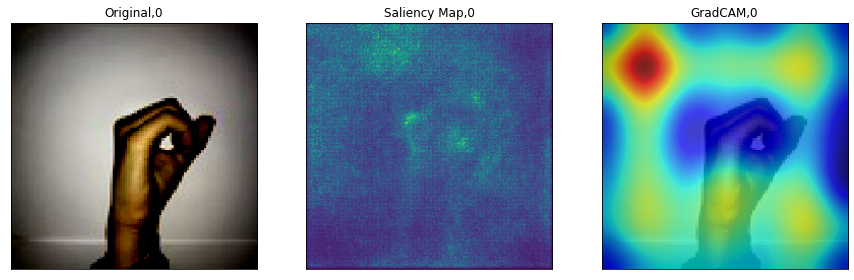

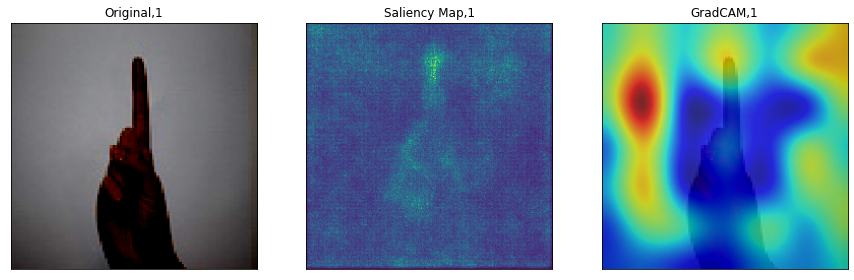

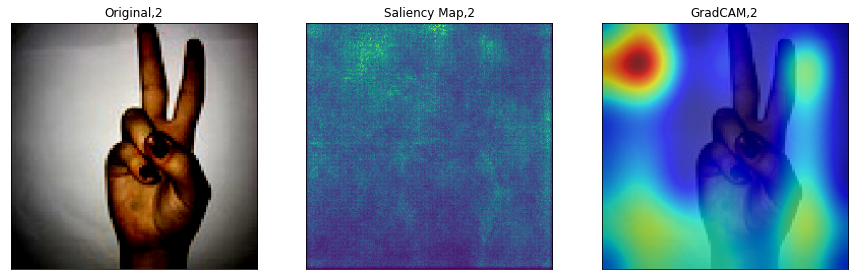

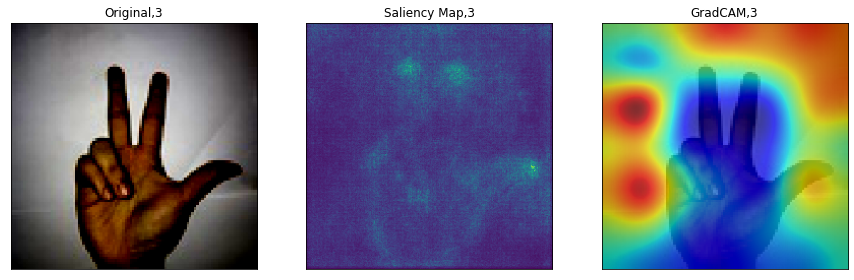

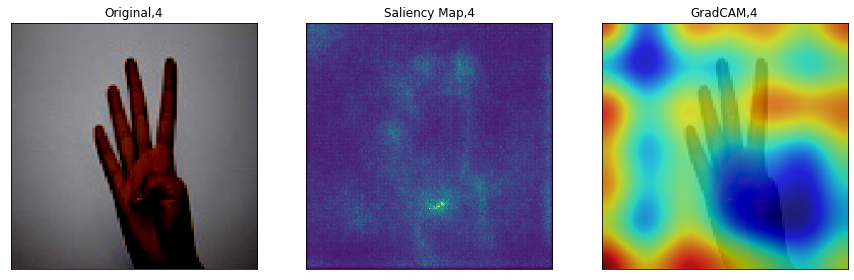

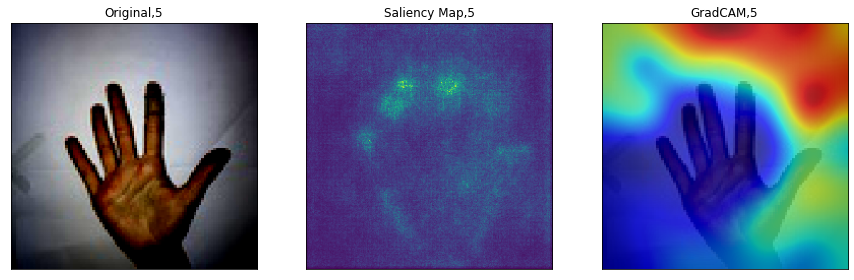

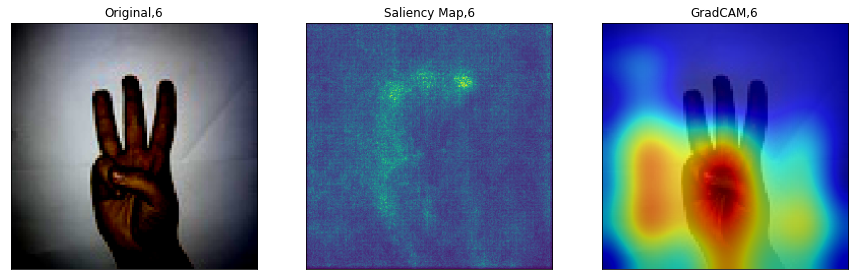

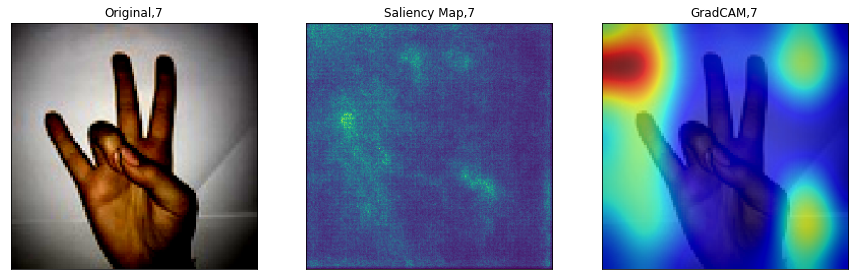

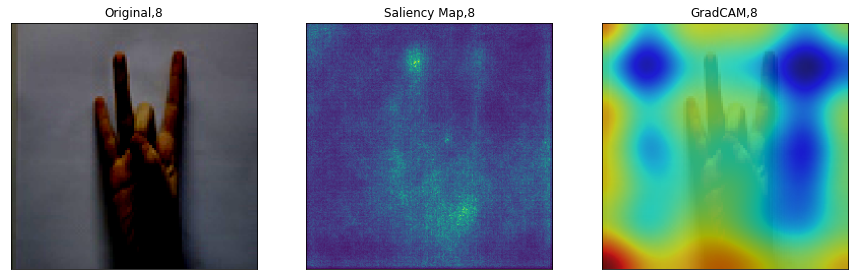

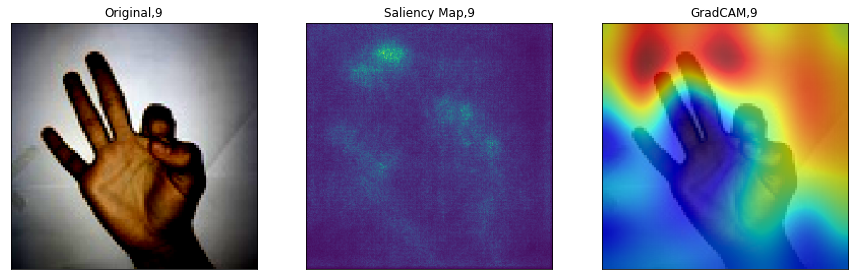

In [39]:
#Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear 
    
# create Saliency object
i = 0
while i < 10:
    image = image_list[i]
    saliency = Saliency(model, model_modifier)

# define loss function. Pass it the correct class label.
    newloss = lambda output: backend.mean(output[:, pred_list[i]])

# Generate saliency map with smoothing that reduce noise by adding noise
    saliency_map = saliency(newloss, image, smooth_samples=20)
    saliency_map = normalize(saliency_map)

# Gradcam object
    gradcam = Gradcam(model = model, model_modifier=model_modifier)
    cam = normalize(gradcam(newloss, image))
    
## Step 5: Visualize Salizancy Map
# remove the first 'batch' dimension added by preprocessing
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5),
                     subplot_kw={'xticks': [], 'yticks': []})
    ax[0].imshow(np.clip(image[0], 0, 1))
    ax[0].set_title(f'Original,{i}')

    ax[1].imshow(saliency_map[0])
    ax[1].set_title(f'Saliency Map,{i}')

    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    ax[2].imshow(np.clip(image[0], 0, 1))
    ax[2].imshow(heatmap, cmap='BrBG', alpha=0.7)
    ax[2].set_title(f'GradCAM,{i}')
    plt.show
    i+=1

Finally, we visualize the testing and evaluation process.

We plot both the loss and accuracy of train and test for trained model. And use a confusion matrix to evaluate the classification performance of the model.

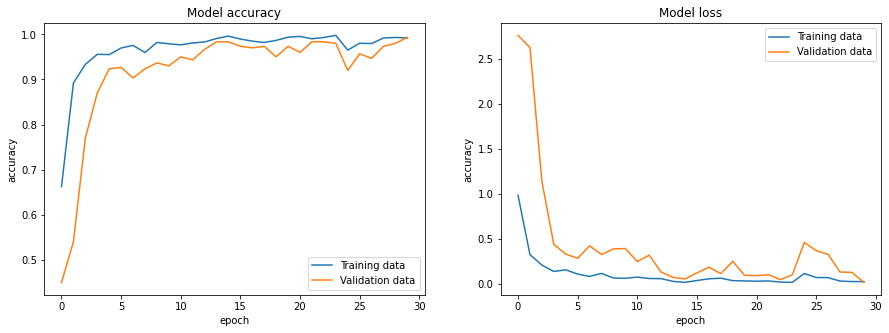

In [40]:
#plot accuracy and loss
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].plot(history.history['accuracy'], label = "Training data")
ax[0].plot(history.history['val_accuracy'], label = "Validation data")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Model accuracy")
ax[0].legend()

ax[1].plot(history.history['loss'], label = "Training data")
ax[1].plot(history.history['val_loss'], label = "Validation data")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].set_title("Model loss")
ax[1].legend()
plt.show()

After that, we call the confusion matrix function provided by lab7. 

The confusion matrix can summarize the gestures in the data set according to the real label and the label predicted by the classification model. The rows of the matrix represent the labels of real gestures, and the columns of the matrix represent the labels of predicted gestures.

In [41]:
test_labels = test_batches.classes

In [42]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [45]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


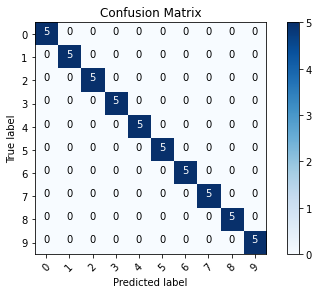

In [46]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

From the results, all the images in the test data are correctly classified. This  proves that Mobilenetv2 has extremely strong classification performance while reducing large amount of parameters.

## Reference


[1]Sik-Ho Tsang. "Review: MobileNetV2 — Light Weight Model (Image Classification)", from Towards Data Science, May 2019<br>(https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c)

[2]Paul-Louis Pröve. "MobileNetV2: Inverted Residuals and Linear Bottlenecks", from Towards Data Science, Apr 2018<br>https://towardsdatascience.com/mobilenetv2-inverted-residuals-and-linear-bottlenecks-8a4362f4ffd5

[3]Mohammed Alnakli. "Training and Deploying A Deep Learning Model in Keras MobileNet V2 and Heroku: A Step-by-Step", from Hacker Noon, October 2018<br>(https://hackernoon.com/tf-serving-keras-mobilenetv2-632b8d92983c)

[4]Mark Sandler, Andrew Howard, et al. "MobileNetV2: Inverted Residuals and Linear Bottlenecks", arXiv:1801.04381 [cs.CV],  Mar 2019 <br>(https://arxiv.org/abs/1801.04381)

[5]Rakshith Vasudev. "Understanding and Calculating the number of Parameters in Convolution Neural Networks (CNNs)", from Towards Data Science, Feb 2019<br>(https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d)